## 1. Import dataset

In [1]:
from helpers import *  
import os

INPUT_DIR = "."
OUT_DIR   = "./out"

os.makedirs(OUT_DIR, exist_ok=True)

FILES = {
    "V1": "V1_first_prompt.txt",
    "V2": "V2_rubric_grade.txt",
    "V3": "V3_improvements_list.txt",
    "V4": "V4_revised_essay.txt",
}

# check files exist
check_files(INPUT_DIR, FILES)


V1 -> V1_first_prompt.txt exists: True
V2 -> V2_rubric_grade.txt exists: True
V3 -> V3_improvements_list.txt exists: True
V4 -> V4_revised_essay.txt exists: True


# 2: Read tokens

In [2]:
v1_path = os.path.join(INPUT_DIR, FILES["V1"])

v1_text = read_text(v1_path)

print(v1_text[:500])  # print first 500 characters

The Relationship Between Social Service Spending and Economic Growth: An Empirical Analysis of OECD Countries 

The relationship between government social spending and economic growth has been a subject of intense academic and policy debate for decades. Traditional economic theory suggests that extensive welfare states may create disincentives to work and investment, potentially hampering economic growth. However, contemporary research presents a more nuanced view, recognizing that social spendi


# 3: Count words

In [3]:
ESSAYS = {}

for key, fname in FILES.items():
    
    ESSAYS[key] = read_text(f"{INPUT_DIR}/{fname}")

list(ESSAYS.keys()), len(ESSAYS["V1"]), len(ESSAYS["V4"])

print("Word counts for V1 and V4 is:")

len(tokens(ESSAYS["V1"])), len(tokens(ESSAYS["V4"]))


Word counts for V1 and V4 is:


(1207, 2662)

In [4]:
# =========================
# PARAMS
# =========================
CSV_PATH = "/Users/ramihuunguyen/Documents/PhD/AI-Assessment/claudeai/causation/causation_transitions.csv"
TOP_K = 10

# =========================
# CODE (simple)
# =========================
import pandas as pd

df = pd.read_csv(CSV_PATH)
df['phrase_norm'] = df['phrase'].str.strip().str.lower()

# how many sources mention each phrase?
per_phrase_sources = (
    df.groupby('phrase_norm')['source']
      .nunique()
      .sort_values(ascending=False)
)

# how many total mentions (all rows)?
per_phrase_total = (
    df['phrase_norm']
      .value_counts()
      .sort_values(ascending=False)
)

# build a small table
table = pd.DataFrame({
    'sources_mentioning': per_phrase_sources,
    'total_mentions': per_phrase_total
}).fillna(0).astype({'sources_mentioning': 'int', 'total_mentions':'int'})

# top-k by sources mentioning (tie-break by total mentions)
table = table.sort_values(by=['sources_mentioning','total_mentions'], ascending=False)
print(table.head(TOP_K))


                  sources_mentioning  total_mentions
phrase_norm                                         
consequently                       5               5
hence                              5               5
therefore                          5               5
thus                               5               5
as a result                        4               4
accordingly                        3               3
because                            3               3
so                                 3               3
for this purpose                   2               2
since                              2               2


# 4: Causation Words

In [7]:
# =========================
# STEP 0: setup
# =========================
import os, pathlib, pandas as pd

# where your essays live
INPUT_DIR = "."   # change if needed

FILES = {
  "V1": "V1_first_prompt.txt",
  "V2": "V2_rubric_grade.txt",
  "V3": "V3_improvements_list.txt",
  "V4": "V4_revised_essay.txt",
}

# resolve paths
RESOLVED = {k: str(pathlib.Path(INPUT_DIR) / v) for k, v in FILES.items()}

def read_text(path):
    return pathlib.Path(path).read_text(encoding="utf-8", errors="ignore")

# =========================
# STEP 1: causation words
# =========================
TOP_CAUSATION = ["consequently", "hence", "therefore", "thus"]
LESS_CAUSATION = ["as a result", "accordingly", "because", "so", "for this purpose", "since"]

# =========================
# STEP 2: count markers
# =========================
def count_markers(text, markers):
    text = text.lower()
    return {m: text.count(m) for m in markers}

results = {}
for essay_id, path in RESOLVED.items():
    txt = read_text(path)
    results[essay_id] = count_markers(txt, TOP_CAUSATION + LESS_CAUSATION)

# =========================
# STEP 3: table
# =========================
df = pd.DataFrame(results).T  # essays as rows, words as columns
df


,consequently,hence,therefore,thus,as a result,accordingly,because,so,for this purpose,since
V1,0,0,0,0,0,0,0,63,0,1
V2,0,0,0,0,0,0,0,6,0,0
V3,0,0,0,0,0,0,0,7,0,0
V4,0,0,0,0,0,0,1,106,0,3


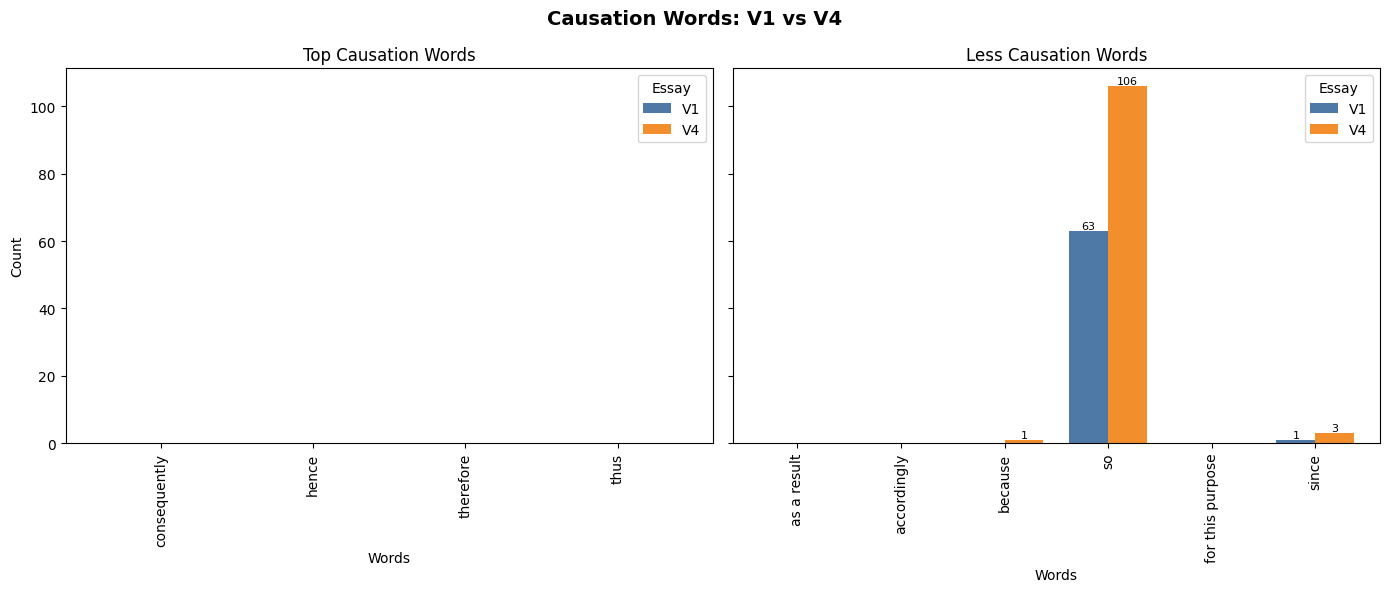

In [9]:
# =========================
# STEP 4: visualization (V1 vs V4; Top vs Less)
# =========================
import matplotlib.pyplot as plt

ESSAYS = ["V1", "V4"]  # focus on V1 and V4 only

# keep only columns that actually exist in df
top_cols  = [w for w in TOP_CAUSATION  if w in df.columns]
less_cols = [w for w in LESS_CAUSATION if w in df.columns]

# subset rows (essays) and columns (word groups)
df_v = df.loc[ESSAYS]

fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# left: Top causation words
(df_v[top_cols].T).plot(kind="bar", ax=axes[0], width=0.75, color=["#4e79a7", "#f28e2b"])
axes[0].set_title("Top Causation Words")
axes[0].set_xlabel("Words")
axes[0].set_ylabel("Count")
axes[0].legend(title="Essay")

# right: Less causation words
(df_v[less_cols].T).plot(kind="bar", ax=axes[1], width=0.75, color=["#4e79a7", "#f28e2b"])
axes[1].set_title("Less Causation Words")
axes[1].set_xlabel("Words")
axes[1].legend(title="Essay")

# add small numbers on bars
for ax in axes:
    for p in ax.patches:
        h = p.get_height()
        if h > 0:
            ax.annotate(
                str(int(h)),
                (p.get_x() + p.get_width() / 2.0, h),
                ha="center", va="bottom", fontsize=8
            )

fig.suptitle("Causation Words: V1 vs V4", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()
